<a href="https://colab.research.google.com/github/YashNagraj75/Neural-Net/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

In [18]:
from keras.layers import Layer
class BatchNormalization(Layer):
    # Code from: https://github.com/dksakkos/BatchNorm
    def __init__(self,
                 axis=-1,
                 momentum=0.90,
                 name=None,
                 synchronized=False,
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.axis = axis
        self.momentum = momentum
        #super(BatchNormalization, self).__init__()

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="beta",
            shape=(input_shape[self.axis]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="gamma",
            shape=(input_shape[self.axis]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="moving_mean",
            shape=(input_shape[self.axis]),
            initializer=tf.initializers.zeros,
            trainable=False)

        self.moving_variance = self.add_weight(
            name="moving_variance",
            shape=(input_shape[self.axis]),
            initializer=tf.initializers.ones,
            trainable=False)

    def get_moving_average(self, statistic, new_value):
        momentum = self.momentum
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta

In [12]:
def identity_block(X,f,filters,initializer=random_uniform):
  F1,F2,F3 = filters

  X_shortcut = X

  # Build the identity_block
  X = Conv2D(filters = F1,kernel_size = 1,strides=(1,1),padding = "valid",kernel_initializer = initializer(seed = 1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation("relu")(X)

  # Second block
  X = Conv2D(filters = F2,kernel_size = f,strides=(1,1),padding="same",kernel_initializer = initializer(seed = 1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  # Third block of the identity_block
  X = Conv2D(filters=F3,kernel_size=1,strides=(1,1),padding = "valid",kernel_initializer = initializer(seed = 1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)

  return X


In [13]:
# UNQ_C2
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, training=True, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####



    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE

    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)

    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [19]:
# Now a Resnet with 50 layers
def Resnet50(input_shape=(64,64,3),classes = 6, training= True):
  X_input = Input(input_shape)

  # Padding
  X = ZeroPadding2D((3,3))(X_input)

  # Stage 1
  X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  # Stage 2
  X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
  X = identity_block(X, 3, [64, 64, 256])
  X = identity_block(X, 3, [64, 64, 256])


  # Stage 3
  X = convolutional_block(X,f=3,filters = [128,128,512], s = 2)
  X = identity_block(X,3,[128,128,512])
  X = identity_block(X,3,[128,128,512])
  X = identity_block(X,3,[128,128,512])

  # Stage 4
  X = convolutional_block(X,f=3,filters = [256, 256, 1024], s = 2)
  X = identity_block(X,3,[256, 256, 1024])
  X = identity_block(X,3,[256, 256, 1024])
  X = identity_block(X,3,[256, 256, 1024])
  X = identity_block(X,3,[256, 256, 1024])
  X = identity_block(X,3,[256, 256, 1024])

  # Stage 5
  X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
  X = identity_block(X, 3, [512, 512, 2048])
  X = identity_block(X, 3, [512, 512, 2048])

  # Average Pooling
  X = AveragePooling2D()(X)
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

  model = Model(inputs = X_input, outputs = X)

  return model

In [20]:
tf.keras.backend.set_learning_phase(True)

model = Resnet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 70, 70, 3)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d_1[0][0]']        

In [22]:

import h5py
import math
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    # your train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(
        train_dataset["train_set_y"][:])  # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    # your test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(
        test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [23]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [26]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [27]:
model.fit(X_train,Y_train,epochs=10,batch_size=32)

Epoch 1/10
34/34 [==============================] - 52s 163ms/step - loss: 1.9202 - accuracy: 0.3074
Epoch 2/10
34/34 [==============================] - 3s 88ms/step - loss: 1.1839 - accuracy: 0.5500
Epoch 3/10
34/34 [==============================] - 3s 100ms/step - loss: 0.7576 - accuracy: 0.7102
Epoch 4/10
34/34 [==============================] - 3s 100ms/step - loss: 0.4746 - accuracy: 0.8389
Epoch 5/10
34/34 [==============================] - 3s 94ms/step - loss: 0.2583 - accuracy: 0.9065
Epoch 6/10
34/34 [==============================] - 3s 90ms/step - loss: 0.1895 - accuracy: 0.9278
Epoch 7/10
34/34 [==============================] - 3s 89ms/step - loss: 0.1683 - accuracy: 0.9352
Epoch 8/10
34/34 [==============================] - 4s 119ms/step - loss: 0.1552 - accuracy: 0.9444
Epoch 9/10
34/34 [==============================] - 3s 92ms/step - loss: 0.0802 - accuracy: 0.9731
Epoch 10/10
34/34 [==============================] - 3s 88ms/step - loss: 0.1076 - accuracy: 0.9556


In [28]:
model.evaluate(X_test,Y_test)

4/4 [==============================] - 3s 34ms/step - loss: 0.6564 - accuracy: 0.8333


[0.6564350128173828, 0.8333333134651184]

In [35]:
img = image.load_img("/content/new.jpg",target_size=(64,64))

Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 104ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[0.01309593 0.02211386 0.01382275 0.5448868  0.32826105 0.07781959]]
Class: 3


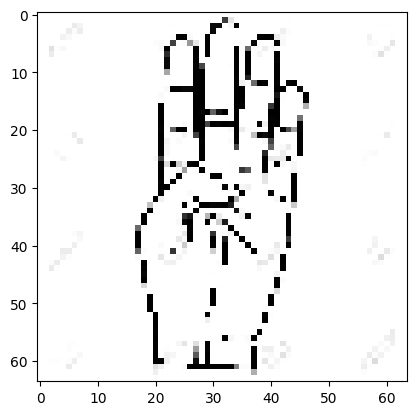

In [36]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
x2 = x
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))
